# Assignment 1b Notebook
This notebook will build off of progress made in Assignment 1a to guide you through the implementation of a basic evolutionary algorithm (EA). As such, you should copy your random initialization function from `linear_genotype.py` from the previous assignment repo to the repo for this assignment. **Do not copy the entire `linear_genotype.py` file**, just the random initialization function you wrote. If you receive any feedback about the implementation of that algorithm in 1a, please address any problems before you conduct your experiment for 1b. You should also copy over your random search statistical data, which should have been saved as `data/random_results.txt`. You may also copy your Assignment 1a notebook over if you wish, but be careful to not overwrite the other files in the repo, as we may have made modifications to them.

Please complete this notebook and read *all* text cells. As usual, start by evaluating the next cell (`shift+enter`) to configure the notebook.

In [4]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import os
import statistics
from multiprocessing import Pool
from snake_eyes import read_config
from cutting_stock.fitness_functions import base_fitness_function
from stock_population_evaluation import base_population_evaluation
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from selection import *
from log_analyzer import *

print('The first cell has been executed!')

The first cell has been executed!


## Evolutionary Algorithm
The algorithms you will be implementing in this course are black-box search algorithms (BBSAs). Black-box refers to the idea that these algorithms use no problem-specific knowledge in order to search for solutions. These algorithms are often described as using a "generate-and-test" methodology, as a BBSA uses the scores observed from previous solutions to guide its search. In many real-world optimization problems, similar solutions often have similar scores. Thus, by iteratively generating new solutions that are similar to the best solutions seen so far, the algorithm can (hopefully!) find even better solutions. EAs fall into this category of algorithm.

The following diagram depicts the flow of a standard EA:
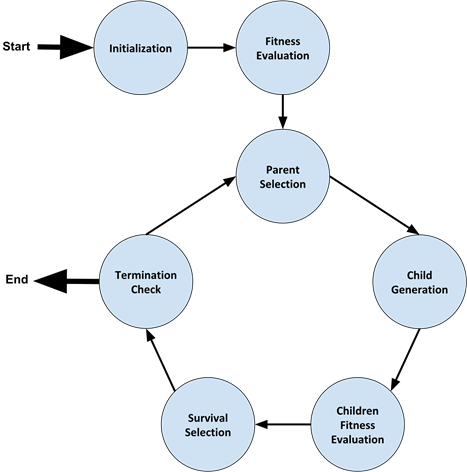

There are many different ways to implement an EA, but in this class we're providing you with a partially-complete framework that demonstrates a modular way to structure code and maximize code re-use throughout the assignments. This means you can gain experience with a codebase similar to what we use in research *and* it means we can just give you code for some of the more mundane and unimportant parts of an EA. Namely, we can give you a configuration parser we use in research. You already used it in Assignment 1a, but we deferred explanation until now.

### The snake_eyes Configuration Parser
The [snake_eyes configuration parser](https://github.com/DeaconSeals/snake_eyes) was developed for research in our lab and is specifically designed for frameworks like the one you'll be working with. The GitHub repo has more general-purpose documentation for using this configuration parser if you're interested in reading more, but the short version is that it takes a configuration file and converts it into a nested dictionary containing the sections and key-value pairs from your configuration file. That's only somewhat different than the [built-in Python configuration parser](https://docs.python.org/3/library/configparser.html) (which [snake_eyes](https://github.com/DeaconSeals/snake_eyes) is built on top of). The most valuable part of [snake_eyes](https://github.com/DeaconSeals/snake_eyes) is that it performs interpolation to determine types and dynamically execute expressions during parsing. This lets us do things like reference constants, functions, and even pass arguments for those functions all from within the configuration file!

This approach might seem a bit quirky, but it can drastically reduce the amount of code refactoring required to add new functionality and we're giving you an example configuration file to show off how to use it. Note that when you call `read_config`, you should pass it three parameters. The first is the path to the config, while the other two parameters should be calls to `globals()` and `locals()`, in that order. The following cell will parse our 1b configuration file and show you its contents:

In [2]:
# Note the calls to globals() and locals()
config = read_config('configs/1b_green_config.txt', globals(), locals())

# The config is stored as a dictionary of dictionaries
# Note the DEFAULT header; this will not be used in our course, and is an artifact of Python's config parser
print('These are the [header] names for the 1b config:')
for key in config.keys():
    print(key)
print()

# Access the contents of a [header] by using it as a key
print('These are the values within the problem header:')
print(config['problem'])
print()

# Access the individual variables similarly
print('This is the value of the bounds variable:')
print(config['problem']['bounds'])

del config

These are the [header] names for the 1b config:
DEFAULT
ea
recombination_kwargs
parent_selection_kwargs
survival_selection_kwargs
mutation_kwargs
problem

These are the values within the problem header:
{'bounds': ((0, 50), (0, 15)), 'shapes': [[(-2, 1), (-2, 0), (-1, 0), (-2, -1), (0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (0, 2), (3, 0)], [(0, -1), (0, 0), (1, -1), (0, 1), (0, 2), (2, -1), (-1, -1), (-1, 1)], [(1, 0), (0, 0), (0, 1), (1, -1), (0, -1), (1, 1), (0, 2), (0, -2), (0, 3), (0, -3), (1, -2), (1, 3), (1, -3), (1, 2)], [(0, -1), (0, 0), (0, 1), (1, 1), (1, -1)], [(0, -1), (0, 0), (1, -1), (2, -1), (3, -1), (-1, 0), (-1, 1), (-2, 0), (-1, -1)], [(1, 1), (2, 1), (2, 0), (1, 0), (0, 1), (-1, 1)], [(1, 1), (2, 1), (2, 0), (0, 1), (0, 0), (-1, 1), (-2, 1), (-2, 0)], [(-2, 1), (-1, 1), (0, 1), (1, 1), (-1, 2), (1, 2), (0, 0), (2, 1), (-1, 0), (-1, -1), (2, 0), (-2, -1), (1, 0), (-2, 0)], [(0, 0), (0, -1), (1, 0), (0, 1), (2, 0), (1, 1), (0, 2), (1, 2), (1, 3), (-1, 2), (2, 2), (-1, 0)

### Aside: Keyword Parameter Unpacking
Dictionary unpacking is an intermediate-level Python technique that we'll make extensive use of throughout the course. It allows you to effortlessly pass any parameters that are required by a function without actually listing the variables in the callsite code. This is the primary way you will utilize the config.

Unpacking a dictionary into a function call sends all the key-value pairs to the function as if they were passed as keywords (as in `function(key1=value1, key2=value2, ...)`). We couple this with function definitions that accept any and all keyword arguments. If a function needed two parameters, `arg1` and `arg2`, it could be written `def function(arg1, arg2, **kwargs)`. Then, inside the function, any passed keyword arguments other than `arg1` and `arg2` are stored in the `kwargs` dictionary.

Execute the following cell for a brief demo of how to accept arbitrary named arguments and unpack named arguments from a dictionary. If you find yourself confused by this example or just want to read more, see [here](https://realpython.com/python-kwargs-and-args/).

In [3]:
def outer_example_function(arg1, arg2, **kwargs):
    print('Outer function takes arg1 and arg2:')
    print('\targ1:', arg1)
    print('\targ2:', arg2)
    print('\tkwargs:', kwargs)
    print()
    inner_example_function(**kwargs)

def inner_example_function(arg3, arg4, arg5, **kwargs):
    print('Inner function takes arg3, arg4, and arg5:')
    print('\targ3:', arg3)
    print('\targ4:', arg4)
    print('\targ5:', arg5)
    print('\tkwargs:', kwargs)

parameter_dict = {'arg1': 'first',
                  'arg2': 'second',
                  'arg3': 'third',
                  'arg4': 'fourth',
                  'arg5': 'fifth',
                  'arg6': 'sixth'}
print('Parameters:', parameter_dict)
print()
outer_example_function(**parameter_dict)

del parameter_dict, outer_example_function, inner_example_function

Parameters: {'arg1': 'first', 'arg2': 'second', 'arg3': 'third', 'arg4': 'fourth', 'arg5': 'fifth', 'arg6': 'sixth'}

Outer function takes arg1 and arg2:
	arg1: first
	arg2: second
	kwargs: {'arg3': 'third', 'arg4': 'fourth', 'arg5': 'fifth', 'arg6': 'sixth'}

Inner function takes arg3, arg4, and arg5:
	arg3: third
	arg4: fourth
	arg5: fifth
	kwargs: {'arg6': 'sixth'}


In order to make sure your code is ready for this assignment and works as intended, we'll carry out a brief (and not very thorough) test of your `LinearGenotype.random_initialization` implementation in the following cell, using the techniques we just showed off. We'll use parameters from our configuration file to both test `random_initialization` and evaluate the fitness of the generated solution. You saw this in Assignment 1a, but you may not have understood what exactly was happening under the hood until now.

The random_initialization function did something? True
Was the solution the right length? True
The solution has fitness -50, and looks like this:


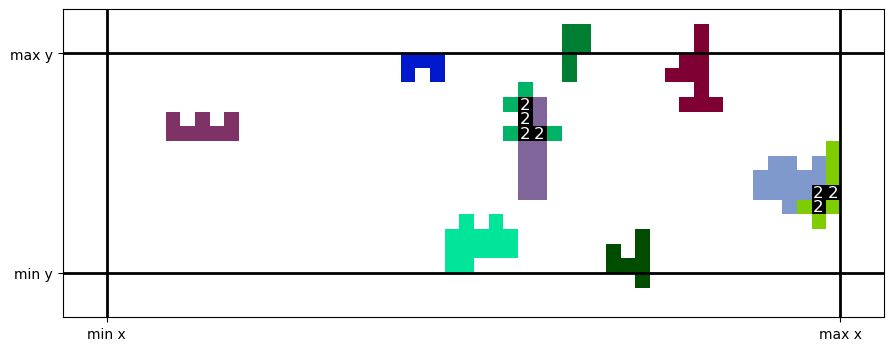

In [4]:
config = read_config('configs/1b_green_config.txt', globals(), locals())
test_solution = LinearGenotype()
test_solution.random_initialization(**config['problem'])

print('The random_initialization function did something?', test_solution.genes is not None)
print('Was the solution the right length?', len(test_solution.genes) == len(config['problem']['shapes']))

output = base_fitness_function(test_solution.genes, **config['problem'])
test_solution.fitness = output['fitness']
test_solution.visualize = output['visualize']

print(f'The solution has fitness {test_solution.fitness}, and looks like this:')
test_solution.visualize()

del config, test_solution, output

### Initialization
Recall that the random search algorithm implemented in Assignment 1a is functionally equivalent to the initialization step performed at the beginning of an EA. While there are alternative initialization methods that seed the initial population with known-good solutions or even perform a preliminary search, randomly generating initial solutions is the most common choice in practice.

Those of you who have looked at the other member functions of the `LinearGenotype` class may have noticed the `initialization` class method. In Assignment Series 2 you will need to write your own population initialization function, but for Assignment Series 1 we are providing you with the function to do this. The code for `LinearGenotype.initialization` is as follows:

```python
class LinearGenotype():
    ...
    @classmethod
    def initialization(cls, mu, *args, **kwargs):
        population = [cls() for _ in range(mu)]
        for i in range(len(population)):
            population[i].random_initialization(*args, **kwargs)
        return population
```

This is really just a convenient shorthand for creating and randomly initializing a list of multiple `LinearGenotype`s in one line. As an example, the following cell will use your `LinearGenotype.random_initialization` method to create a population of 10 individuals.

In [5]:
config = read_config('configs/1b_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])

print('Population size:', len(example_population))
print('Number of uninitialized individuals:', [i.genes for i in example_population].count(None))
length = len(config['problem']['shapes'])
print('Number of individuals with correct length:', [len(i.genes) for i in example_population].count(length))

del config, example_population, length

Population size: 10
Number of uninitialized individuals: 0
Number of individuals with correct length: 10


### Fitness Evaluation
Now that you have a function for *initializing* an entire population, the next step is to implement a function for *evaluating* an entire population. Implement the `base_population_evaluation` function in `stock_population_evaluation.py` to evaluate all individuals in an input population. Simply call `base_fitness_function` on each individual's `genes` (along with `**kwargs`), and assign the `fitness` and `visualize` member variables as demonstrated two code cells ago.

We'll test your implementation in the next cell. We will initialize 5000 individuals with `LinearGenotype.initialization`, evaluate them with `base_population_evaluation`, print some information about their fitnesses, and show off the best solution.

Individuals with unassigned fitness: 0
Mean fitness of population: -49.8892
Best fitness in population: 14
The highest-fitness individual looks like this:


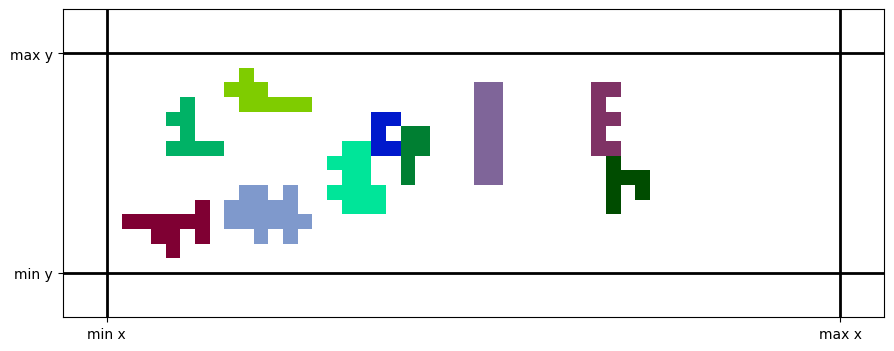

In [6]:
config = read_config('configs/1b_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(5000, **config['problem'])

# Calling your function to test things out
# Note the way the config is unpacked
base_population_evaluation(example_population, **config['problem'])

fitnesses = [individual.fitness for individual in example_population]
print('Individuals with unassigned fitness:', fitnesses.count(None))
print('Mean fitness of population:', statistics.mean(fitnesses))
print('Best fitness in population:', max(fitnesses))
best_individual = max(example_population, key=lambda individual:individual.fitness)

print('The highest-fitness individual looks like this:')
best_individual.visualize()

del config, example_population, fitnesses, best_individual

### Aside: Sampling With and Without Replacement
Stochastically selecting samples from a population is a very common practice in many fields of study, and a critical component of EC implementations. There are two fundamental ways to conduct this sampling: with replacement and without replacement. The names are often explained by an example such as drawing cards from a deck. If you draw a card, you have a choice of whether or not to put it back in the deck before you draw again. If you put it back in the deck, you are replacing it, so you are sampling *with replacement*. If you don't put the card back, you are not replacing it, so you are sampling *without replacement*.

In the context of EC, sampling *with* replacement means the same individual can be selected any number of times. On the other hand, sampling *without* replacement means each individual is selected exactly once or not at all. In general, parent selection is with replacement, while survival selection is without replacement. An individual can have many children in one generation, but logically can't be selected to survive multiple times in one generation -- it either survives, or dies.

**Note**: the textbook regrettably sometimes uses *replacement* as a synonym for *survival selection*, particularly on pages 87-89. To avoid confusion, we will not adopt this vocabulary and strongly discourage its use.

### Parent Selection
After evaluating the initial population, the evolutionary cycle begins with parent selection. You will now implement the parent selection methods in the `selection.py` file. This file also contains survival selection functions that we will implement later. In general, parent selection algorithms can select the same individual multiple times (i.e., an individual can reproduce multiple times in a generation). Selection functions take as input a population as well as `n`, the number of individuals that should be selected from that population. Individual functions may also have additional parameters, which we will explain as they come up.

To start off, implement `uniform_random_selection` in `selection.py`. This function should select `n` individuals uniform randomly (i.e., with equal probability), with replacement, out of all individuals in the input population.

In [7]:
config = read_config('configs/1b_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

num_parents = 20
parents = uniform_random_selection(example_population, num_parents)

print('The function did something?', parents is not None)
print('The correct number of parents were selected?', len(parents) == num_parents)
del config, example_population, num_parents, parents

The function did something? True
The correct number of parents were selected? True


Now implement `k_tournament_with_replacement` in `selection.py`. This algorithm samples `k` individuals from the population then selects the most fit of these as the winner, and repeats this process `n` times. That is, you should conduct `n` different independent tournaments, each of size `k`. **The contestants within each tournament are sampled without replacement**, meaning the `k` individuals in any given tournament are all unique. However, **the algorithm overall samples with replacement**, meaning an individual can win multiple tournaments. The book suggests that the `k` individuals in a tournament may be sampled with or without replacement, but we require it to be *without* replacement.

In [8]:
config = read_config('configs/1b_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

num_parents = 20
parents = k_tournament_with_replacement(example_population, num_parents, k=2)

print('The function did something?', parents is not None)
print('The correct number of parents were selected?', len(parents) == num_parents)

del config, example_population, num_parents, parents

The function did something? True
The correct number of parents were selected? True


Finally, implement `fitness_proportionate_selection` in `selection.py` to select `n` individuals with a probability proportional to their fitness in the entire population. Again, this is with replacement. In this assignment series, fitness values can sometimes be negative. This means that you can't simply calculate probabilities as each individual's fitness divided by the total population fitness. **If** you have negative fitness within the population, **then** it's necessary to instead calculate selection weights based on fitness, rather than using fitness values directly. There are several methods to overcome this limitation, but our suggested approach is to subtract the minimum fitness in the population from all fitness values to form nonnegative weights that may be used instead. When doing this, make sure you are using local variables instead of changing the actual fitness value members!

**Note:** To be clear, only calculate scaled selection weights **if** negative fitness exists within the population. When doing this, look out for the edge case where all fitnesses are negative and equal (hint: selection probabilities in this case are uniform).

In [9]:
config = read_config('configs/1b_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

num_parents = 20
parents = fitness_proportionate_selection(example_population, num_parents)

print('The function did something?', parents is not None)
print('The correct number of parents were selected?', len(parents) == num_parents)

del config, example_population, num_parents, parents

The function did something? True
The correct number of parents were selected? True


### Recombination
Once parents are selected, their genetic information is recombined to produce a new individual. Fixed-length linear genotypes have several performant and simple recombination methods. These will be implemented in the `LinearGenotype.recombine` method found in `linear_genotype.py`. You will implement uniform recombination and 1-point crossover (Section **4.2.2** in the textbook), treating the placement for each shape as an atomic allele (i.e., recombination should take the x, y, and rotation values for a shape all together).

Note that you can add any necessary arguments to the `recombination_kwargs` section of `configs/1b_green_config.txt`. `LinearGenotype.recombine` takes as input a mate, a method, and any arguments you require, initializes a `child` object of the type `LinearGenotype`, recombines the `genes` member variables of `self` and `mate` to populate the `genes` member variable of `child`, and then returns the `child` object. It is **strongly** advised that you use the `deepcopy` function from the `copy` module when copying alleles from parent to child. Unless you are an experienced Python developer, it is very easy for naïve shallow copies to cause *incredibly* frustrating and subtle bugs. While deepcopies are computationally expensive and often unnecessary, they are the simplest option for preventing these issues for less-experienced developers. The following cell will reload the config to retrieve any new parameters you've added and test your implementation.

In [74]:
config = read_config('configs/1b_green_config.txt', globals(), locals())
parents = LinearGenotype.initialization(2, **config['problem'])
parent0 = parents[0]
parent1 = parents[1]

child = parent0.recombine(parent1, **config['recombination_kwargs'])
print('The function did something?', child.genes is not None)
print('The child genes are the right length?', len(child.genes) == len(parent0.genes))

# testing for actual recombination of multiple genes
for i in range(len(parent0.genes)):
    parent0.genes[i] = (1, 1, 1)
    parent1.genes[i] = (2, 2, 2)

child = parent0.recombine(parent1, **config['recombination_kwargs'])
print('The child genes contain information from both parents?', (1, 1, 1) in child.genes and (2, 2, 2) in child.genes)
print('The child genes only contain information from parents?', all([x == (1, 1, 1,) or x == (2, 2, 2) for x in child.genes]))

del config, parents, parent0, parent1, child

The function did something? True
The child genes are the right length? True
The child genes contain information from both parents? True
The child genes only contain information from parents? True


### Mutation
Mutation is a method for introducing variance and additional genetic information into the population. In the base EA we're implementing now, mutation has a chance to occur on children just produced from recombination based on a configurable mutation rate. Thus, the mutation rate parameter of an EA controls how often new children are mutated. The `LinearGenotype.mutate` method in `linear_genotype.py` that you're about to implement assumes that the individual (`self`) has already been selected to mutate via an external mechanism. In other words, your `LinearGenotype.mutate` function should nearly always result in a mutation of some kind (i.e., there should be no conditional that tries to prevent a mutation from occurring).

You may implement mutation however you wish, but we require that your implementation is capable of changing all 3 values in an allele (not necessarily all at once), and is capable of producing new values even if they don't already exist in the population (unlike recombination). For inspiration, you may want to look at canonical mutation functions for integer genotypes (reset mutation and creep mutation; see Section **4.3.1** in the textbook). However, keep in mind the valid ranges for each value (the x bounds, y bounds, and 0, 1, 2, or 3 rotations). Your mutation should not produce any values outside of these valid ranges. You should also avoid the somewhat common mistake of having an extremely destructive mutation function; it should only change a relatively small amount of the genes, not act like a new random reinitialization.

Like the recombination function, you can add any necessary parameters to the config's `mutation_kwargs` section. `LinearGenotype.mutate` takes an individual and these parameters as input, and returns a new individual (i.e., you don't modify the calling object). In this case, modify the `copy` object instantiated within the function and return it. Also like recombination, we **strongly** advise you to use `deepcopy`. The following cell will reload the config to retrieve any new parameters you've added and test your implementation. Note that some mutation implementations might rarely not result in a change, if the mutated values are coincidentally the same as the input values (i.e., sampling a new rotation value might only cause a change 3/4 of the time, since there are only four valid values, one of which is the input). We consider such implementations valid, so it's not necessary to pass the second test in this cell 100% of the time, but it should be a solid majority of the time.

In [97]:
config = read_config('configs/1b_green_config.txt', globals(), locals())

original = LinearGenotype.initialization(1, **config['problem'])[0]
mutant = original.mutate(**config['mutation_kwargs'])

print('The mutant genes were the right length?', len(original.genes) == len(mutant.genes))

different = False
for i in range(len(original.genes)):
    for j in range(len(original.genes[i])):
        if original.genes[i][j] != mutant.genes[i][j]:
            different = True
print('The mutant was changed?', different)

del config, original, mutant, different

The mutant genes were the right length? True
The mutant was changed? True


### Child Generation
There are multiple ways to select parents, but the two most common approaches are the following:
 * Select all parents at once to form a "parent pool", then iterate over it and generate children
 * Repeatedly select pairs of parents to generate one child at a time

Both techniques have scenarios where they make more or less sense to use, but **in these assignments you will be using a parent pool**. We have provided you with the code to create a parent pool using the selection algorithms you've implemented. However, it's important to consider and minimize sampling error in your implementation. As a rule of thumb, avoid scenarios where a parent must win a lottery *after* being selected as a parent in order to actually reproduce. That is, don't randomly sample from the pool. You should simply iterate over the pool in pairs.

Now, you must implement the `generate_children` method of the `BaseEvolutionPopulation` class in `BaseEvolution.py`. Note that the member variables of the `BaseEvolutionPopulation` class contain the parent selection function itself in `self.parent_selection`, in addition to member variables with kwargs for parent selection, recombination, and mutation. It also contains `self.num_children`, the number of children to produce ($\lambda$), and `self.mutation_rate`, the probability that each child undergoes mutation. Our implementation uses `num_children` instead of `lambda`, the preferred EC term, because `lambda` is a reserved keyword in Python. However, you should understand that these are synonyms.

Implement `BaseEvolutionPopulation.generate_children` such that it utilizes `self.parent_selection` and all other necessary member variables to generate and return a population of children formed from `self.population`. The following cell will test your implementation. For now, ignore how we're using `example_ea`. We are also temporarily overriding the `num_children` value in `1b_green_config.txt`, since large values of `num_children` (including the one we gave you for a default) can make testing this function take as long as a full run of the EA!

In [12]:
# Setting up the population; you can ignore this section
config = read_config('configs/1b_green_config.txt', globals(), locals())
config['ea']['num_children'] = 10
example_ea = BaseEvolutionPopulation(**config['ea'], **config)
base_population_evaluation(example_ea.population, **config['problem'])

# Testing your generate_children method
children = example_ea.generate_children()
print('The correct number of children were generated?', len(children) == example_ea.num_children)

del config, example_ea, children

The correct number of children were generated? True


### Survival Selection
Recall from earlier that `selection.py` contained functions for both parent selection and survival selection for you to implement. While parent selection algorithms can generally select the same individual to be a parent multiple times in a given generation (*with replacement*), survival selection must only select unique individuals to survive (*without replacement*). That is to say that no individual in a population should be placed into the surviving population twice and, once selected to survive, an individual must no longer be considered during the same round of survival selection.

We'll start by implementing a classic survival selection method: `truncation`. In the `truncation` survival selection algorithm, the `n` fittest individuals from the input population are selected to survive. Implement the `truncation` function in `selection.py` to behave this way and return the `n` surviving individuals. The next cell will test your implementation.

In [13]:
num_survivors = 2

config = read_config('configs/1b_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

survivors = truncation(example_population, num_survivors)
print('The correct number of survivors were selected?', len(survivors) == num_survivors)
del num_survivors, config, example_population, survivors

The correct number of survivors were selected? True


Now implement the `k_tournament_without_replacement` function in `selection.py`. Like the parent selection version of k-tournament, `k_tournament_without_replacement` takes as input a value `k`, forms tournaments from sampling `k` unique individuals from the input population (*without replacement*), and selects the most fit as the winner of the tournament. Unlike the parent selection version, however, **the winner of each tournament cannot be selected as one of the `k` contestants in future tournaments**. That is, the `k` contestants in each tournament should be individuals that *haven't* previously won a tournament.

The following cell will test your `k_tournament_without_replacement` implementation.

In [14]:
num_survivors = 2

config = read_config('configs/1b_green_config.txt', globals(), locals())
example_population = LinearGenotype.initialization(10, **config['problem'])
base_population_evaluation(example_population, **config['problem'])

survivors = k_tournament_without_replacement(example_population, num_survivors, k=2)
print('The correct number of survivors were selected?', len(survivors) == num_survivors)

del num_survivors, config, example_population, survivors

The correct number of survivors were selected? True


## Unit testing your implementation
Executing the following cell will launch a Bash command to unit test your implementation thus far. This will perform a series of automated tests on the functions you've implemented so far and will attempt to identify any bugs (and save you from later headaches) before you implement your full EA. Note that since your algorithms are highly stochastic, the unit tests have some margin of error. **We recommend running the tests a few times in a row to make sure everything works, but also understand that if any given test fails a small percentage of the time (<10%) it's probably not your algorithm's fault.** You are expected to try to diagnose errors on your own before contacting a TA for assistance. The test results should show you what part of your code might be failing, and what criteria it may be failing to meet. Passing these unit tests is part of your grade -- we will run them, and we expect that every test should pass the majority of the time. Note that some of the unit tests may take a few seconds, since testing stochastic algorithms requires sampling their behavior many times.

A failed assertion is itself generally not helpful (the test's algorithmic implementation is probably not worth the effort to analyze). You should look at the name of the test, the class the test is a part of, and the comment underneath the test's definition. These should point you in the right direction. On the other hand, if the test is failing because of a real error (rather than an assertion), then the stack trace will be very helpful.

In addition, a single bug may cause multiple tests to fail; if you can't understand why one test is failing, you might want to focus on fixing a different test, and see if that fixes several at once.

In [99]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.11.5, pytest-7.4.2, pluggy-1.3.0
rootdir: /home/maf0083/to_run
plugins: anyio-3.5.0
collected 43 items                                                             

tests/test_base_evolution.py .....                                       [ 11%]
tests/test_linear_genotype.py ...........                                [ 37%]
tests/test_selection.py ...........................                      [100%]

============================= 43 passed in 11.16s ==============================


## Assembling the EA framework
Now that you've implemented all the necessary components, it's time to learn how to use the `BaseEvolutionPopulation` class you'll be using throughout this course. This class can be found in `base_evolution.py` and contains some high-level functions that will use your code to implement the major segments of an EA:
 * Initialization
 * Child generation
 * Survival selection

After initialization, we require you to log three values in a specific way. We've provided the code to do this in the cell below. Aside from this logging after initialization, you will log the same values at the end of each generation, and even more values are logged automatically when you call `BaseEvolutionPopulation`'s member functions. This log is not a recommended format for you to parse algorithmically (i.e., you *must* track data for analysis & plotting separately), but is here to help you (and us!) detect problems in your EA.

We'll start by calling initialization, which is provided for you. Note that we'll begin making extensive use of our config dictionary and the `**kwargs` technique.

In [16]:
config = read_config('configs/1b_green_config.txt', globals(), locals())

# Initialize the EA, including an unevaluated population of size mu
example_ea = BaseEvolutionPopulation(**config['ea'], **config)

# Evaluate the initial population
base_population_evaluation(example_ea.population, **config['problem'])

# Keep track of evaluation count
example_ea.evaluations = len(example_ea.population)

# Add values to the log after the initial generation
example_ea.log.append(f'Evaluations: {example_ea.evaluations}')
example_ea.log.append(f'Local best: {max(map(lambda x:x.fitness, example_ea.population))}')
example_ea.log.append(f'Local mean: {statistics.mean(map(lambda x:x.fitness, example_ea.population))}')

# Print statements for tutorialization
print('Population size:', len(example_ea.population))
print('Average fitness of population:', statistics.mean([individual.fitness for individual in example_ea.population]))
print('Best fitness in population:', max([individual.fitness for individual in example_ea.population]))
print('Evaluation count:', example_ea.evaluations)

Population size: 50
Average fitness of population: -50
Best fitness in population: -50
Evaluation count: 50


Now that the population is initialized and evaluated, it's time to make children for the next generation. You should have already implemented the `generate_children` function. As when we demonstrated that function, we're temporarily lowering `num_children` to save you some time. In a ($\mu$+$\lambda$)-EA, the children are simply added to the population alongside the parents:

In [17]:
# Lowering num_children for this example
example_ea.num_children = 10

# Genereate children
children = example_ea.generate_children()

# Evaluate children
base_population_evaluation(children, **config['problem'])

# Update evaluation count
example_ea.evaluations += len(children)

# Add evaluated children to the adult population
example_ea.population += children

# Print statements for tutorialization
print('Number of children made:', len(children))
print('Average fitness of children:', statistics.mean([individual.fitness for individual in children]))
print('Best fitness of children:', max([individual.fitness for individual in children]))
print('New population size:', len(example_ea.population))
print('Evaluation count:', example_ea.evaluations)

Number of children made: 10
Average fitness of children: -50
Best fitness of children: -50
New population size: 60
Evaluation count: 60


We will now call the provided `BaseEvolutionPopulation.survival` method to perform survival selection using the algorithms you've implemented, reducing the population back to size $\mu$:

In [18]:
# Perform survival selection
example_ea.survival()

# Add values to the log at the end of each generation
example_ea.log.append(f'Evaluations: {example_ea.evaluations}')
example_ea.log.append(f'Local best: {max(map(lambda x:x.fitness, example_ea.population))}')
example_ea.log.append(f'Local mean: {statistics.mean(map(lambda x:x.fitness, example_ea.population))}')

# Print statements for tutorialization
print('New population size:', len(example_ea.population))
print('Average fitness of survivors:', statistics.mean([individual.fitness for individual in example_ea.population]))
print('Best fitness of survivors:', max([individual.fitness for individual in example_ea.population]))

New population size: 50
Average fitness of survivors: -50
Best fitness of survivors: -50


In [19]:
# execute this cell to clean up variables left over from the previous cells
del config, example_ea, children

Now combine everything we just showed you to write a function that performs one run of a ($\mu$+$\lambda$) EA. You should initialize a `BaseEvolutionPopulation`, evaluate the population, then have a generational loop that creates children, evaluates them, and performs survival selection. The loop should continue until you have conducted `number_evaluations` total evaluations.

**Don't forget to log evaluation count and mean/max fitness values after your initial evaluations, and after each generation, as shown in the example cells**. In addition to the unit tests, we also have code that attempts to validate your EA's overall behavior based on values that are logged over the course of your run. While it is by no means proof of (in)correctness, it can bring atypical behavior to your attention. The code we've given you in the following cell calls this analysis function for you after each run.

In addition, for logging your own data, make sure you log values after evaluating the initial population *in addition to* logging values at the end of your generational loop.

In [100]:
from math import inf
from typing import Tuple, List

get_fitness = lambda x: x.fitness

def local_best_and_mean(population: List[LinearGenotype]) -> Tuple[LinearGenotype,float]:
    '''Given a population, returns the best solution and the average pop fitness'''
    fittest_individual = max(population, key = get_fitness)
    mean_fitness = statistics.mean(map(get_fitness, population))
    return fittest_individual, mean_fitness

def evolutionary_algorithm_search(number_evaluations: int, config_filename: str):
    global_fittest = None
    config = read_config(config_filename, globals(), locals())
    base_ea = BaseEvolutionPopulation(**config['ea'], **config)
    data_log = []
    
    # eval initial population
    base_population_evaluation(base_ea.population, **config['problem'])
    base_ea.evaluations = len(base_ea.population)
    
    #Add values to the log after the initial generation
    base_ea.log.append(f'Evaluations: {base_ea.evaluations}')
    # on the first round, we can assign global_fittest to be some arbitrary individual 
    global_fittest, local_mean_fitness = local_best_and_mean(base_ea.population)
    base_ea.log.append(f'Local best: {global_fittest.fitness}')
    base_ea.log.append(f'Local mean: {local_mean_fitness:.3f}')
    data_log.append(f"{base_ea.evaluations} {global_fittest.fitness} {local_mean_fitness}")


    ### Start Children Section ###
    while(base_ea.evaluations < number_evaluations):
        children = base_ea.generate_children()

        #evaluate children
        base_population_evaluation(children, **config['problem'])
        base_ea.evaluations += len(children)
        base_ea.population += children

        # Do selection to determine who survives
        base_ea.survival()

        # log values
        base_ea.log.append(f'Evaluations: {base_ea.evaluations}')
        local_fittest, local_mean_fitness = local_best_and_mean(base_ea.population)
        global_fittest = max((global_fittest, local_fittest), key=get_fitness)
        base_ea.log.append(f'Local best: {local_fittest.fitness}')
        base_ea.log.append(f'Local mean: {local_mean_fitness:.3f}')
        data_log.append(f"{base_ea.evaluations} {local_fittest.fitness} {local_mean_fitness}")
        

    # Load this with your BaseEvolutionPopulation's log member after the run.
    log = base_ea.log

    # This will print outputs if it looks like anything has gone wrong.
    analyze_base_log(log)

    return log, data_log, global_fittest

38


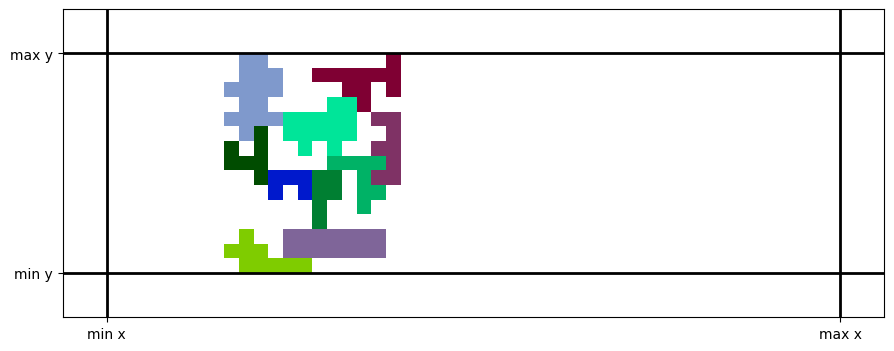

In [103]:
# Testing one run of your EA (don't worry if the results are very poor, you'll improve it later on!)
log, data_log, global_fittest = evolutionary_algorithm_search(1_000_000, 'configs/1b_green_config.txt')

# Save the logged values to a file for you to view
# Note that printing the log often fails; too much data all at once
with open('example_log.txt', 'w') as f:
    f.write(format_log(log))

# Print the other outputs
print(global_fittest.fitness)
global_fittest.visualize()

### Tuning Your EA
Did the call to your EA return underwhelming results? If you passed the unit tests, your EA (probably) isn't broken and this is most likely a result of the poorly-tuned parameters in the config file. Parameter tuning is an important part of using an EA in practice, and we didn't want to rob you of this critical experience by providing well-tuned parameters. In fact, we have intentionally filled the config with several values that are either disastrous to performance, cause undesired behavior, or are simply invalid. Except for the problem-instance-specific parameters (ones we've left comments telling you to not touch), you are expected to examine every configured value, think critically about what its impact on your EA is, and (if necessary) change it to a more sensible value. Part of your grade depends on improving these values before your conduct your experiment.

Parameter tuning (and doing so fairly) is an entire problem within itself that you could devote tremendous amounts of time to. For this assignment though, we just ask that you informally tune your EA such that it consistently outperforms random search, though we encourage you to tune the parameters to the best of your ability. For informal hand-tuning, it's common to perform some small number of runs (let's say around 5) for each configuration in order to estimate its (stochastic) performance. Repeat this process with different parameters a few times and try to find reasonable values, but don't spend an exorbitant amount of time here.

Use the following cell to informally tune your EA by changing the parameters in `configs/1b_green_config.txt`. Be careful not to tune the problem-instance-specific parameters (which we've left comments saying not to touch!) as doing so fundamentally changes the problem in a way that invalidates the comparison of results.

In [102]:
tuning_runs = 8
number_evaluations = 1_000_000
config_filename = 'configs/1b_green_config.txt'

# Sample function call:
def one_run(i):
    log, data_log, global_fittest = evolutionary_algorithm_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_fittest.fitness}")
    return global_fittest

with Pool() as pool:
    res = pool.map(one_run, range(tuning_runs))

Run 3: 38
Run 2: 40
Run 7: 38
Run 5: 39
Run 4: 38
Run 1: 38
Run 0: 38
Run 6: 39


## Experiment
Now, implement code to perform 30 runs of your EA search that each perform 1,000,000 evaluations. For each generation of each run, log the mean and best fitness of the current population as well as the number of fitness evaluations performed so far (including the initial population). For each run, log the best fitness found (for statistical analysis). For the solution with the highest fitness across all runs, visualize it. Save all experimental data to the `data/1b/green` subdirectory in an easily-understood format. The saved data should be sufficient to recreate your report from scratch. Note that the data stored in your `BaseEvolutionPopulation`'s `log` member is NOT considered sufficient; you should log data separately, in your own format, and save those _in addition to_ the automatic logs.

In [2]:
number_runs = 30
number_evaluations = 1_000_000
config_filename = 'configs/1b_green_config.txt'


# Sample function call:
def one_run(i):
    log, data_log, global_fittest = evolutionary_algorithm_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_fittest.fitness}")
    return (log, data_log, global_fittest.genes, global_fittest.fitness)

os.makedirs('data/1b/green/logs/', exist_ok=True)
with Pool() as pool:
    res = pool.map(one_run, range(number_runs))
    
res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_fitness = res[i]
    with open(f'data/1b/green/logs/{str(i+1)}.txt', 'w') as f:
        f.write(format_log(log))
    with open(f'data/1b/green/logs/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))

In [25]:
stats_data = []
best_genotypes = []
for i in range(number_runs):
    with open(f'data/1b/green/logs/{i+1}_data.txt','r') as f:
        # the best fitness found is stored on the first line
        max_fit = int(f.readline().strip())
        stats_data.append(max_fit)
        # second line has the genes that created that fitness
        # turns the string into a list, as its printed right for that
        max_gene = eval(f.readline().strip())
        best_genotypes.append(max_gene)
print(f"Best fitness found in index {stats_data.index(max(stats_data))} with value {max(stats_data)}")
# Writing your statistical data to a file
with open('data/1b/green/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')
# Write the best gene data to a file
with open('data/1b/green/best_genes.txt', 'w') as f:
    best_idx = stats_data.index(max(stats_data))
    f.write(str(best_genotypes[best_idx]) + "\n")

Best fitness found in index 8 with value 40


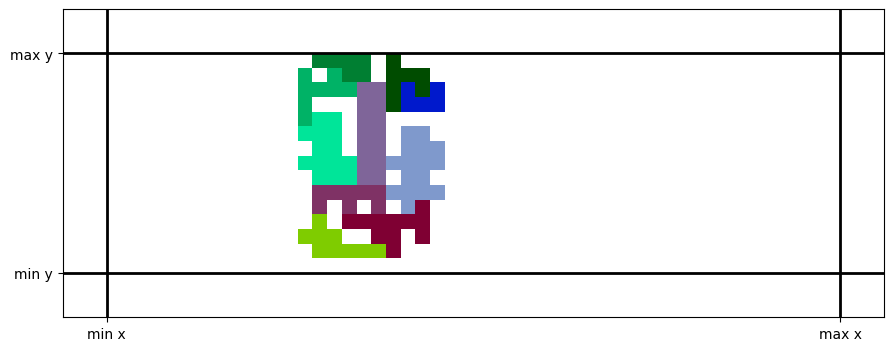

In [22]:
config_filename = 'configs/1b_green_config.txt'
config = read_config(config_filename, globals(), locals())

#visualize best gene
with open('data/1b/green/best_genes.txt', 'r') as f:
    best_gene = eval(f.readline().strip())
    output = base_fitness_function(best_gene, **config['problem'])
    output['visualize']()

## Report
Now you have the data required to complete the report described in the assignment document. There are components of the report you need to complete independently, but this notebook will walk you through generating the plots and conducting statistical analysis.

### Statistical Analysis
Statistical analysis should consist of a comparison between best per-run fitness values of your EA searches with the data you generated during your experiment in Assignment 1a. That data should have been saved in your Assignment 1a repository under `data/random_results.txt`. If you have not already done so, copy that file to this assignment's `data` subdirectory. Then you can run the below cell and interpret the results as you did in the previous assignment. Recall that we specify $\alpha=0.05$ for these tests.

In [106]:
import statistics
from scipy import stats

with open('data/1b/green/statistics.txt', 'r') as f:
    ea_data = [int(line) for line in f.readlines()]

print('1b data mean:', statistics.mean(ea_data))
print('1b data stdv:', statistics.stdev(ea_data))

# Reading the data from your 1a experiment
with open('data/random_results.txt', 'r') as f:
    random_data = [int(line) for line in f.readlines()]

print('1a data mean:', statistics.mean(random_data))
print('1a data stdv:', statistics.stdev(random_data))

test_result = stats.ttest_ind(random_data, ea_data, equal_var=False)
print('p-value:', test_result.pvalue)

1b data mean: 38.733333333333334
1b data stdv: 0.8276819867946673
1a data mean: 24.966666666666665
1a data stdv: 1.7515182248421006
p-value: 3.3749280310602546e-34


### Evals-vs-fitness Plot
Using the data you've collected from your 30 run experiment, analyze your fitness values to find the mean and maximum population fitnesses at each generation averaged over your 30 runs. That is, for each run, you should have recorded a mean and max fitness at each generation. For each generation, calculate the average mean fitness and average max fitness across all 30 runs at that generation. If you store your data such that `means[run][gen]` is the mean fitness at generation `gen` in run `run`, then the average mean fitness for generation `0` is the values of `means[run][0]` averaged across all runs. Likewise, the average mean fitness for generation `x` is the values of `means[run][x]` averaged across all runs, and similar for the maximum fitness.

Using this data, plot the *number of evaluations* (not generations) versus the mean and maximum fitness averaged over 30 runs. The following cell has code to generate the plot, but you need to calculate and set the x and y values appropriately.

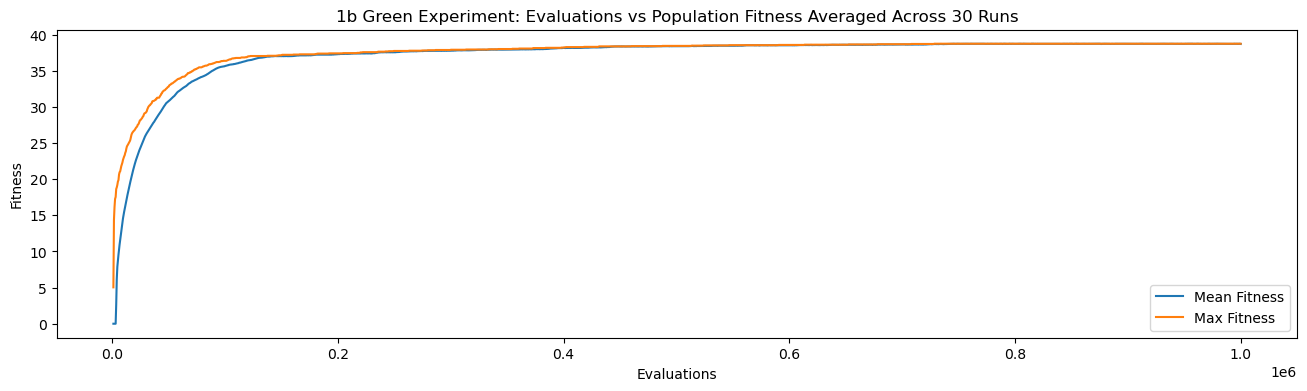

In [12]:
'''
Store the y-values for mean fitness in average_means,
and the y-values for best fitness in average_maxes.
x-values should represent the number of **evaluations**, NOT **generations**.
Store the evaluation counts in the evals variable.
'''
evals = None
total_maxes = None
total_means = None
for i in range(number_runs):
    curr = []
    with open(f'data/1b/green/logs/{i+1}_data.txt', 'r') as f:
        idx = 0
        for line in f:
            # drop the first 2 lines describing the globally best solution in that run
            idx += 1
            if idx <= 2: continue
            #take off newline char and split it by space
            data = line.strip().split()
            curr.append(data)
    if evals == None:
        evals = [int(x[0]) for x in curr]
    if total_maxes == None:
        total_maxes = [float(x[1]) for x in curr]
    else:
        for i, v in enumerate(curr):
            total_maxes[i] += float(v[1])
    if total_means == None:
        total_means = [float(x[2]) for x in curr]
    else:
        for i, v in enumerate(curr):
            total_means[i] += float(v[2])
# if a value would have negatie fitness, make it zero to better see plot
average_means = [(x/number_runs if x/number_runs > 0 else 0) for x in total_means]
average_maxes = [(x/number_runs if x/number_runs > 0 else 0) for x in total_maxes]

# save plot data
with open('data/1b/green/plot_data.txt', 'w') as f:
    for i in range(len(evals)):
        e, means, maxes = evals[i], average_means[i], average_maxes[i]
        f.write(f"{e} {means} {maxes}\n")

fig, ax = plt.subplots()
ax.plot(evals, average_means)
ax.plot(evals, average_maxes)
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = '1b Green Experiment: Evaluations vs Population Fitness Averaged Across 30 Runs')
ax.legend(['Mean Fitness', 'Max Fitness'])
plt.show()

# Yellow Deliverable (Bonus for 5660 students, required for 6660 students)
If attempting the 1b yellow deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

In [108]:
number_runs = 30
number_evaluations = 1_000_000
config_filename = 'configs/1b_yellow_config.txt'

# Sample function call:
def one_run(i):
    log, data_log, global_fittest = evolutionary_algorithm_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_fittest.fitness}")
    return (log, data_log, global_fittest.genes, global_fittest.fitness)

os.makedirs('data/1b/yellow/logs/', exist_ok=True)
with Pool() as pool:
    res = pool.map(one_run, range(number_runs))
    
res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_fitness = res[i]
    with open(f'data/1b/yellow/logs/{str(i+1)}.txt', 'w') as f:
        f.write(format_log(log))
    with open(f'data/1b/yellow/logs/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))

Run 28: 38
Run 7: 38
Run 5: 40
Run 27: 40
Run 14: 39
Run 21: 38
Run 17: 39
Run 29: 38
Run 19: 39
Run 11: 39
Run 3: 39
Run 10: 38
Run 23: 39
Run 24: 38
Run 2: 38
Run 1: 38
Run 20: 40
Run 8: 39
Run 15: 38
Run 18: 39
Run 13: 39
Run 12: 39
Run 6: 40
Run 9: 39
Run 26: 40
Run 4: 39
Run 16: 38
Run 25: 39
Run 22: 38
Run 0: 40


In [26]:
stats_data = []
best_genotypes = []
for i in range(number_runs):
    with open(f'data/1b/yellow/logs/{i+1}_data.txt','r') as f:
        # the best fitness found is stored on the first line
        max_fit = int(f.readline().strip())
        stats_data.append(max_fit)
        # second line has the genes that created that fitness
        # turns the string into a list, as its printed right for that
        max_gene = eval(f.readline().strip())
        best_genotypes.append(max_gene)
print(f"Best fitness found in index {stats_data.index(max(stats_data))} with value {max(stats_data)}")
# Writing your statistical data to a file
with open('data/1b/yellow/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')
# Write the best gene data to a file
with open('data/1b/yellow/best_genes.txt', 'w') as f:
    best_idx = stats_data.index(max(stats_data))
    f.write(str(best_genotypes[best_idx]) + "\n")

Best fitness found in index 0 with value 40


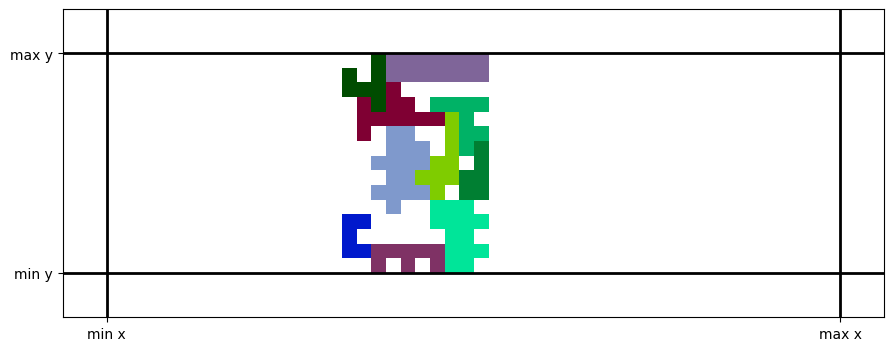

In [19]:
config_filename = 'configs/1b_yellow_config.txt'
config = read_config(config_filename, globals(), locals())

#visualize best gene
with open('data/1b/yellow/best_genes.txt', 'r') as f:
    best_gene = eval(f.readline().strip())
    output = base_fitness_function(best_gene, **config['problem'])
    output['visualize']()

In [9]:
import statistics
from scipy import stats

with open('data/1b/yellow/statistics.txt', 'r') as f:
    yellow_data = [int(line) for line in f.readlines()]

print('yellow data mean:', statistics.mean(yellow_data))
print('yellow data stdv:', statistics.stdev(yellow_data))

# Reading the data from green
with open('data/1b/green/statistics.txt', 'r') as f:
    green_data = [int(line) for line in f.readlines()]

print('green data mean:', statistics.mean(green_data))
print('green data stdv:', statistics.stdev(green_data))

test_result = stats.ttest_ind(green_data, yellow_data, equal_var=False)
print('p-value:', test_result.pvalue)

yellow data mean: 38.833333333333336
yellow data stdv: 0.7466399831028446
green data mean: 38.733333333333334
green data stdv: 0.8276819867946673
p-value: 0.6250396054974117


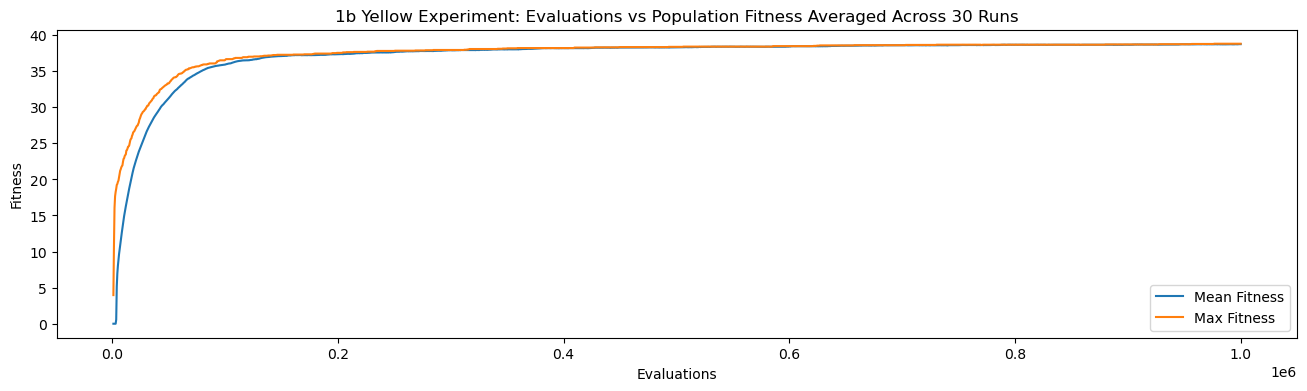

In [11]:
'''
Store the y-values for mean fitness in average_means,
and the y-values for best fitness in average_maxes.
x-values should represent the number of **evaluations**, NOT **generations**.
Store the evaluation counts in the evals variable.
'''
evals = None
total_maxes = None
total_means = None
for i in range(number_runs):
    curr = []
    with open(f'data/1b/yellow/logs/{i+1}_data.txt', 'r') as f:
        idx = 0
        for line in f:
            # drop the first 2 lines describing the globally best solution in that run
            idx += 1
            if idx <= 2: continue
            #take off newline char and split it by space
            data = line.strip().split()
            curr.append(data)
    if evals == None:
        evals = [int(x[0]) for x in curr]
    if total_maxes == None:
        total_maxes = [float(x[1]) for x in curr]
    else:
        for i, v in enumerate(curr):
            total_maxes[i] += float(v[1])
    if total_means == None:
        total_means = [float(x[2]) for x in curr]
    else:
        for i, v in enumerate(curr):
            total_means[i] += float(v[2])

# save plot data
with open('data/1b/yellow/plot_data.txt', 'w') as f:
    for i in range(len(evals)):
        e, means, maxes = evals[i], average_means[i], average_maxes[i]
        f.write(f"{e} {means} {maxes}\n")

# if a value would have negatie fitness, make it zero to better see plot
average_means = [(x/number_runs if x/number_runs > 0 else 0) for x in total_means]
average_maxes = [(x/number_runs if x/number_runs > 0 else 0) for x in total_maxes]
fig, ax = plt.subplots()
ax.plot(evals, average_means)
ax.plot(evals, average_maxes)
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = '1b Yellow Experiment: Evaluations vs Population Fitness Averaged Across 30 Runs')
ax.legend(['Mean Fitness', 'Max Fitness'])
plt.show()

# Red Deliverable (Bonus)
If attempting the 1b red deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

In [113]:
number_runs = 30
number_evaluations = 1_000_000
config_filename = 'configs/1b_red_config.txt'

# Sample function call:
def one_run(i):
    log, data_log, global_fittest = evolutionary_algorithm_search(number_evaluations, config_filename)
    print(f"Run {i}: {global_fittest.fitness}")
    return (log, data_log, global_fittest.genes, global_fittest.fitness)

os.makedirs('data/1b/red/logs/', exist_ok=True)
with Pool() as pool:
    res = pool.map(one_run, range(number_runs))
    
res = list(res)
for i in range(len(res)):
    log, data_log, best_genes, best_fitness = res[i]
    with open('data/1b/red/logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(format_log(log))
    with open(f'data/1b/red/logs/{i+1}_data.txt', 'w') as f:
        f.write(f"{best_fitness}\n")
        f.write(f"{best_genes}\n")
        f.write('\n'.join(data_log))

Run 25: 39
Run 11: 38
Run 16: 40
Run 10: 38
Run 12: 37
Run 13: 39
Run 19: 38
Run 23: 40
Run 0: 38
Run 28: 39
Run 18: 40
Run 2: 40Run 29: 39

Run 21: 39
Run 7: 40
Run 26: 38
Run 1: 38
Run 6: 39
Run 24: 39
Run 9: 37
Run 4: 38
Run 5: 39
Run 14: 38
Run 15: 38
Run 17: 39
Run 3: 37
Run 20: 37
Run 8: 38
Run 27: 38
Run 22: 39


In [24]:
stats_data = []
best_genotypes = []
for i in range(number_runs):
    with open(f'data/1b/red/logs/{i+1}_data.txt','r') as f:
        # the best fitness found is stored on the first line
        max_fit = int(f.readline().strip())
        stats_data.append(max_fit)
        # second line has the genes that created that fitness
        # turns the string into a list, as its printed right for that
        max_gene = eval(f.readline().strip())
        best_genotypes.append(max_gene)
print(f"Best fitness found in index {stats_data.index(max(stats_data))} with value {max(stats_data)}")
# Writing your statistical data to a file
with open('data/1b/red/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')
# Write the best gene data to a file
with open('data/1b/red/best_genes.txt', 'w') as f:
    best_idx = stats_data.index(max(stats_data))
    f.write(str(best_genotypes[best_idx]) + "\n")

Best fitness found in index 2 with value 40


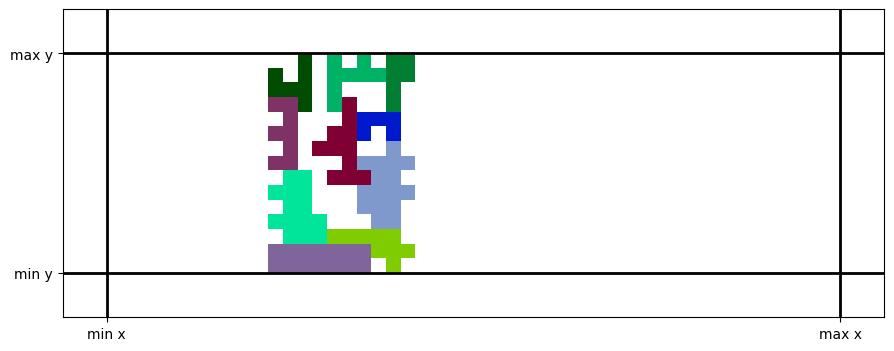

In [23]:
config_filename = 'configs/1b_red_config.txt'
config = read_config(config_filename, globals(), locals())

#visualize best gene
with open('data/1b/red/best_genes.txt', 'r') as f:
    best_gene = eval(f.readline().strip())
    output = base_fitness_function(best_gene, **config['problem'])
    output['visualize']()

In [115]:
import statistics
from scipy import stats

with open('data/1b/red/statistics.txt', 'r') as f:
    red_data = [int(line) for line in f.readlines()]

print('red data mean:', statistics.mean(red_data))
print('red data stdv:', statistics.stdev(red_data))

# Reading the data from green
with open('data/1b/green/statistics.txt', 'r') as f:
    green_data = [int(line) for line in f.readlines()]

print('green data mean:', statistics.mean(green_data))
print('green data stdv:', statistics.stdev(green_data))

test_result = stats.ttest_ind(green_data, red_data, equal_var=False)
print('p-value:', test_result.pvalue)

red data mean: 38.53333333333333
red data stdv: 0.9371024061116425
green data mean: 38.733333333333334
green data stdv: 0.8276819867946673
p-value: 0.3846152091409889


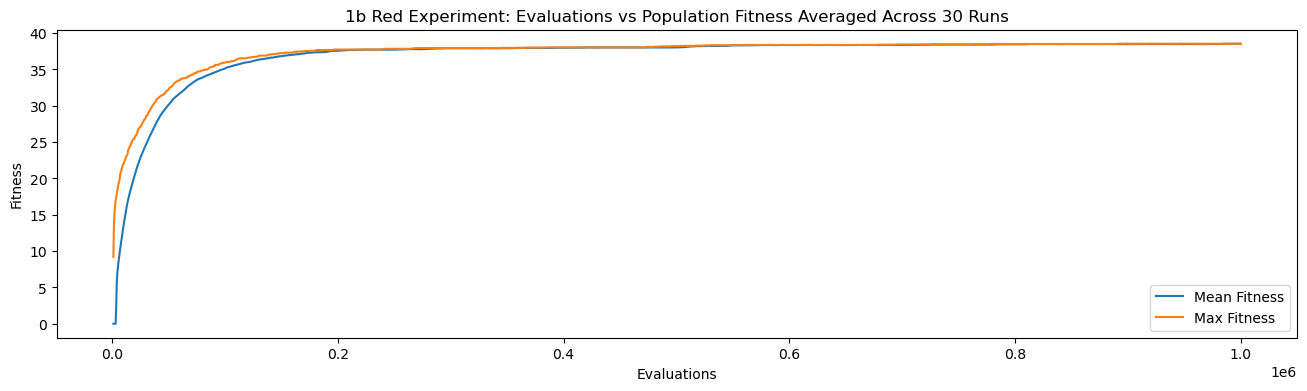

In [14]:
'''
Store the y-values for mean fitness in average_means,
and the y-values for best fitness in average_maxes.
x-values should represent the number of **evaluations**, NOT **generations**.
Store the evaluation counts in the evals variable.
'''
evals = None
total_maxes = None
total_means = None
for i in range(number_runs):
    curr = []
    with open(f'data/1b/red/logs/{i+1}_data.txt', 'r') as f:
        idx = 0
        for line in f:
            # drop the first 2 lines describing the globally best solution in that run
            idx += 1
            if idx <= 2: continue
            #take off newline char and split it by space
            data = line.strip().split()
            curr.append(data)
    if evals == None:
        evals = [int(x[0]) for x in curr]
    if total_maxes == None:
        total_maxes = [float(x[1]) for x in curr]
    else:
        for i, v in enumerate(curr):
            total_maxes[i] += float(v[1])
    if total_means == None:
        total_means = [float(x[2]) for x in curr]
    else:
        for i, v in enumerate(curr):
            total_means[i] += float(v[2])
            
# save plot data
with open('data/1b/red/plot_data.txt', 'w') as f:
    for i in range(len(evals)):
        e, means, maxes = evals[i], average_means[i], average_maxes[i]
        f.write(f"{e} {means} {maxes}\n")
        
# if a value would have negatie fitness, make it zero to better see plot
average_means = [(x/number_runs if x/number_runs > 0 else 0) for x in total_means]
average_maxes = [(x/number_runs if x/number_runs > 0 else 0) for x in total_maxes]
fig, ax = plt.subplots()
ax.plot(evals, average_means)
ax.plot(evals, average_maxes)
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = '1b Red Experiment: Evaluations vs Population Fitness Averaged Across 30 Runs')
ax.legend(['Mean Fitness', 'Max Fitness'])
plt.show()